# Imports

In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib import cm
import scipy
import scipy.signal
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import opening, binary_erosion, binary_opening, binary_closing

In [2]:
# https://ipython.readthedocs.io/en/stable/config/options/terminal.html
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

# Source Image

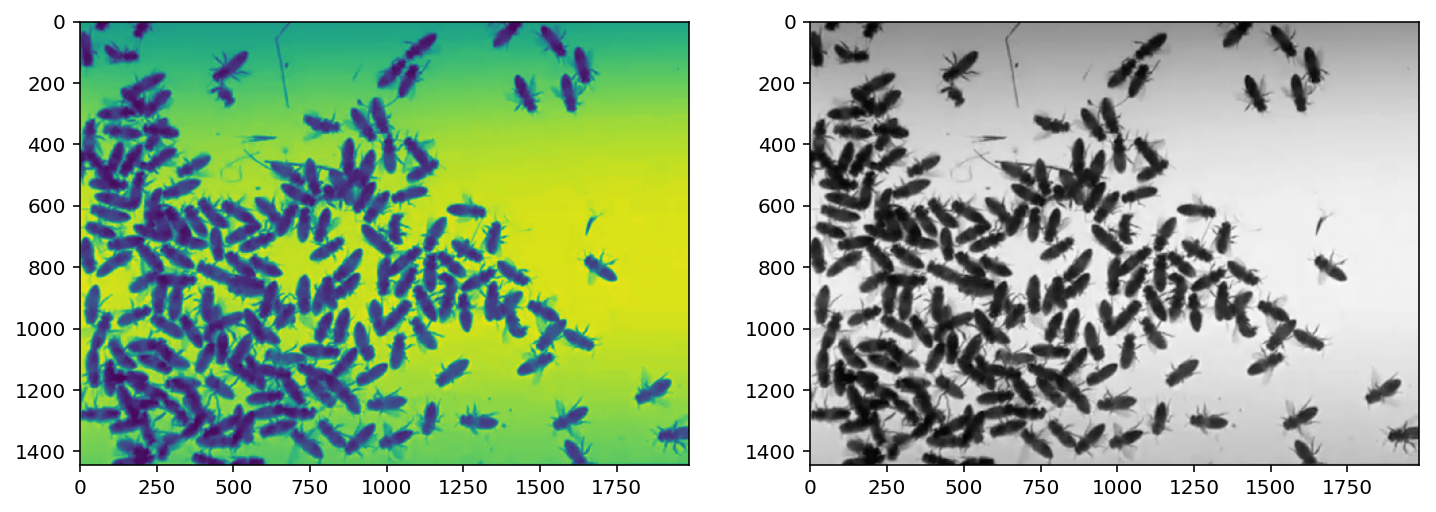

In [4]:
img_src = "bees.png"
img_orig = cv2.imread(img_src)
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(img)
ax[1].imshow(img, cmap=plt.cm.gray)

src_img = np.copy(img)

# Threshold Image

In [4]:
def threshold_image(img, show=False):
    _, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_TOZERO)
    _, img_otsu_binary = cv2.threshold(img_otsu, 0, 255, cv2.THRESH_BINARY_INV)
    
    if show:
        fig, ax = plt.subplots(1,3,figsize=(18,12))
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title("Original")
        ax[1].imshow(img_otsu, cmap=plt.cm.gray)
        ax[1].set_title("Otsu To Zero")
        ax[2].imshow(img_otsu_binary, cmap=plt.cm.gray)
        ax[2].set_title("Otsu Binary")
        
    return img_otsu_binary

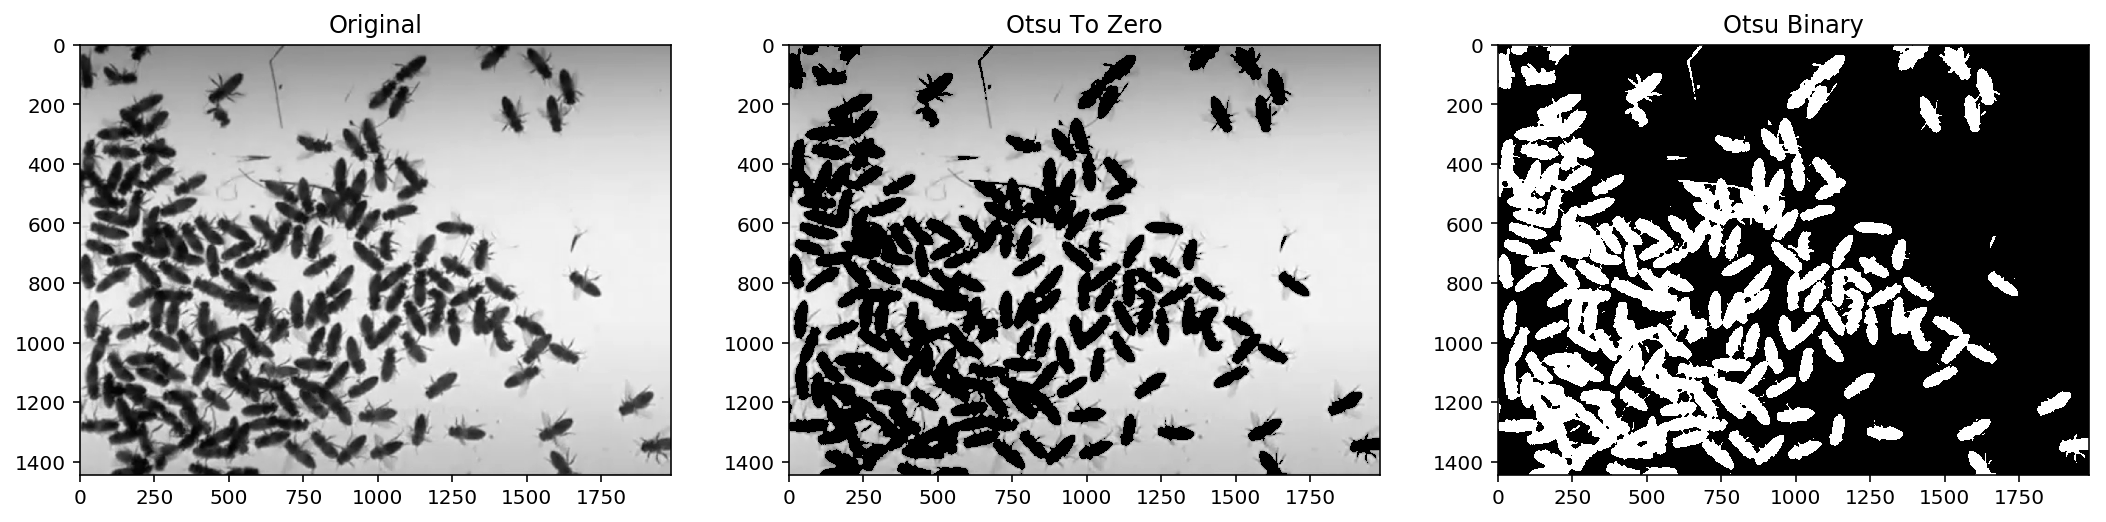

In [6]:
otsu_img = threshold_image(src_img, show=True)

## Erosion

In [37]:
def get_erroded_img(img, local=False, global_threshold=70, show=False):
    if local:
        eroded_img = binary_opening(img)
    else:
        global_thresh_img = ~(img > global_threshold)
        eroded_img = binary_opening(global_thresh_img)
    
    if show:
        fig, ax = plt.subplots(1,2,figsize=(18,12))
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title("Original")
        ax[1].imshow(eroded_img, cmap=plt.cm.gray)
        ax[1].set_title("Eroded Image")
        
    return eroded_img

((1444, 1984), dtype('bool'))

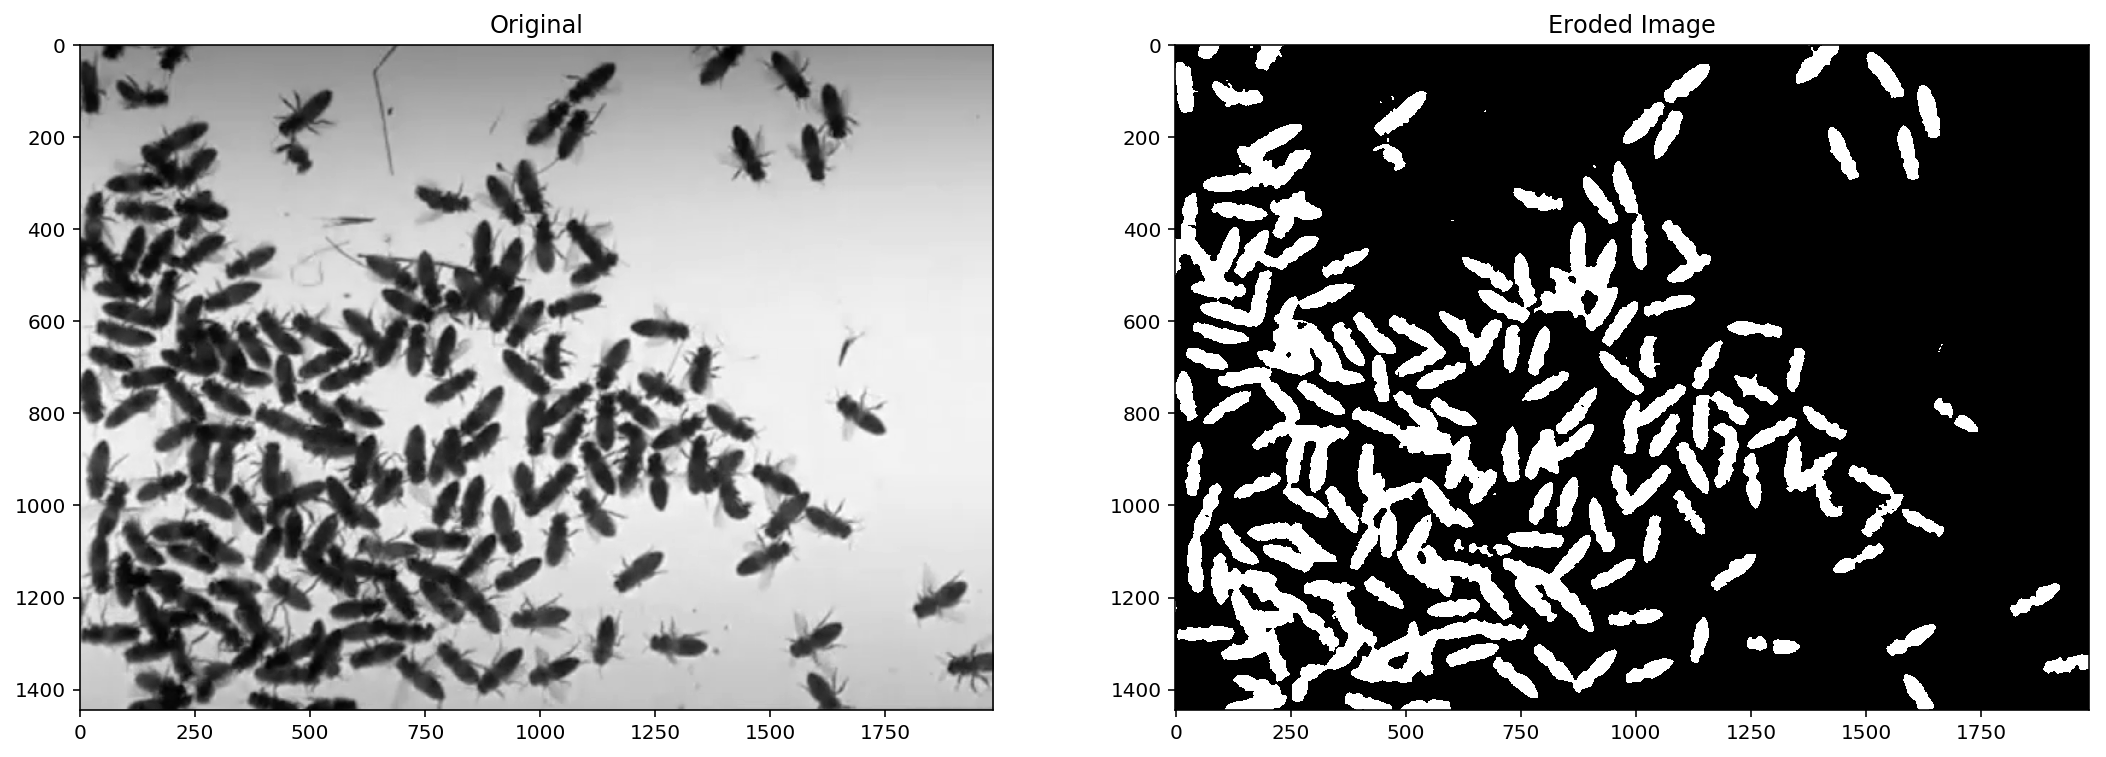

In [38]:
LOCAL = False
src_erode_img = otsu_img if LOCAL else img
eroded_img = get_erroded_img(src_erode_img, local=LOCAL, global_threshold=70, show=True)
eroded_img.shape, eroded_img.dtype

## Canny Edge

In [39]:
def edge_detection(img):
    # Set img to apply Canny detection
    im = img.astype(np.float)
    edge_img = cv2.Canny((im*255).astype(np.uint8), 10, 100)

    # Gauss Blur (helps with stronger edges)
    edge_img = cv2.GaussianBlur(edge_img, (3,3), 0)

    # Otsu threshold + binary again
    _, edge_img = cv2.threshold(edge_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(20,12))
    _ = ax[0].imshow(img, cmap=plt.cm.gray)
    _ = ax[0].set_title('Original')
    _ = ax[1].imshow(edge_img, cmap=plt.cm.gray)
    _ = ax[1].set_title('Canny Edges')

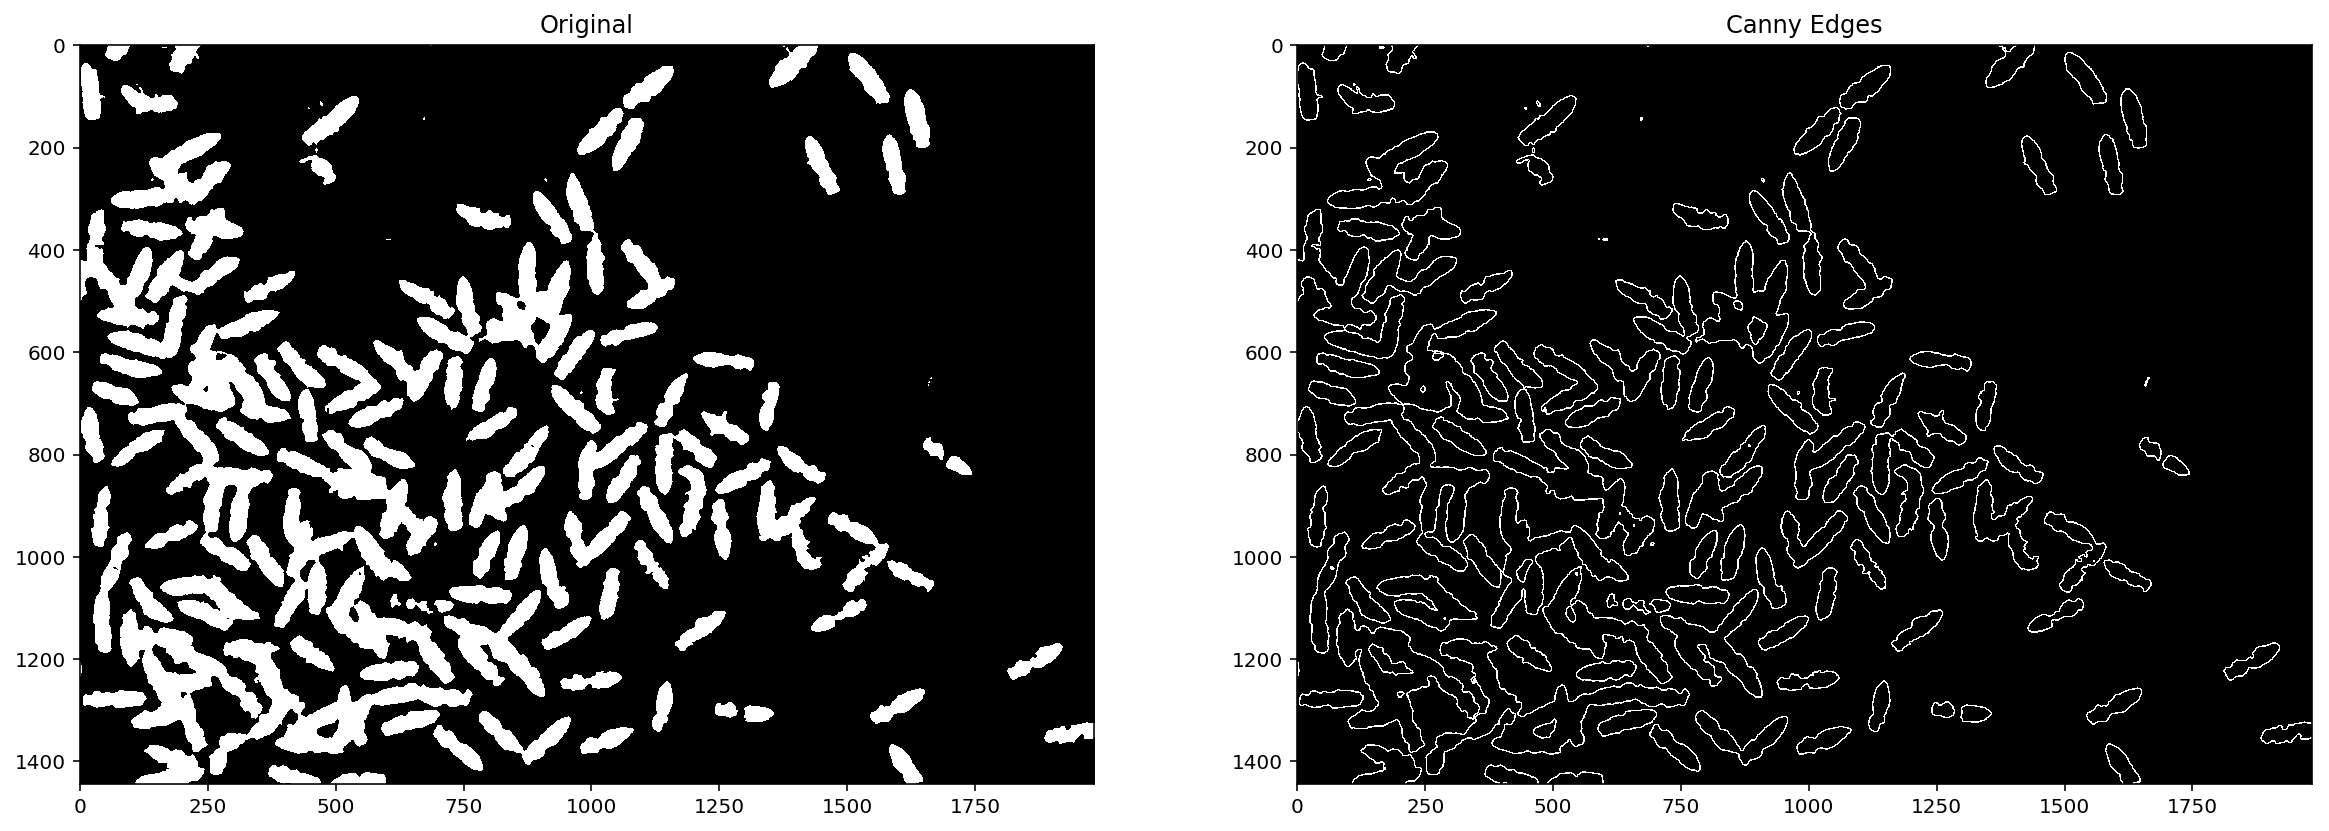

In [40]:
edge_detection(eroded_img)

# Connected Components

In [295]:
label_color = cmap(1.*3/10)
label_color[:3]

(0.2980392156862745, 0.7019607843137254, 1.0)

In [344]:
def create_overlay_img(img_original, stats, centroids, label_color=None, bee_type='good', show=True):
    
    overlay_img = np.copy(img_original).astype(np.uint8)
    
    # Generate overlay image
    if len(img_original.shape) == 2:
        overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_GRAY2RGB)
    
    if overlay_img.max() == 1:
        overlay_img *= 255
        
    if label_color is None:
        label_color = (0,255,0) if bee_type is 'good' else (255, 0, 0)

    
    for stat, centroid in zip(stats, centroids):
        top_left = tuple(stat[:2])
        h,w = stat[2:4]
        bottom_right = (top_left[0]+h, top_left[1]+w)
        centroid_x, centroid_y = centroid.astype(np.int)
        cv2.rectangle(overlay_img, top_left, bottom_right, label_color, 3)
        cv2.circle(overlay_img, (centroid_x, centroid_y), 14, label_color, -1)

    if show:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.imshow(overlay_img)
        
    return overlay_img

In [348]:
def run_connected_components(img, max_factor=0.3, prev_stats=None):
    img = np.copy(img).astype(np.uint8)
    
    # Run connected components
    num_regions, regions, stats, centroids = cv2.connectedComponentsWithStats(img)
    
    # Filter out by area
    MIN_AREA = 2000
    MAX_AREA = np.product(img.shape[:2])*max_factor # Half of image area
    
    condition = (stats[:,-1] < MAX_AREA) & (stats[:,-1] > MIN_AREA)

    new_stats = stats[condition]
    new_centroids = centroids[condition]
    
    if len(new_centroids) == 0:
        return None, None
    
    if prev_stats is None:
        stats = {
            "local"  : new_stats,
            "global" : new_stats
        }
        centroids = new_centroids
    else:
        global_stats = np.copy(new_stats)
        for crop_i in range(len(global_stats)):
            global_stats[crop_i,:2] += prev_stats[:2]
        stats = {
            "local"  : new_stats,
            "global" : global_stats
        }
        centroids = new_centroids
        for centroid_i in range(len(centroids)):
            centroids[centroid_i][0] += prev_stats[0]
            centroids[centroid_i][1] += prev_stats[1]
        
    return stats, centroids

In [43]:
new_stats, new_centroids = run_connected_components(eroded_img)

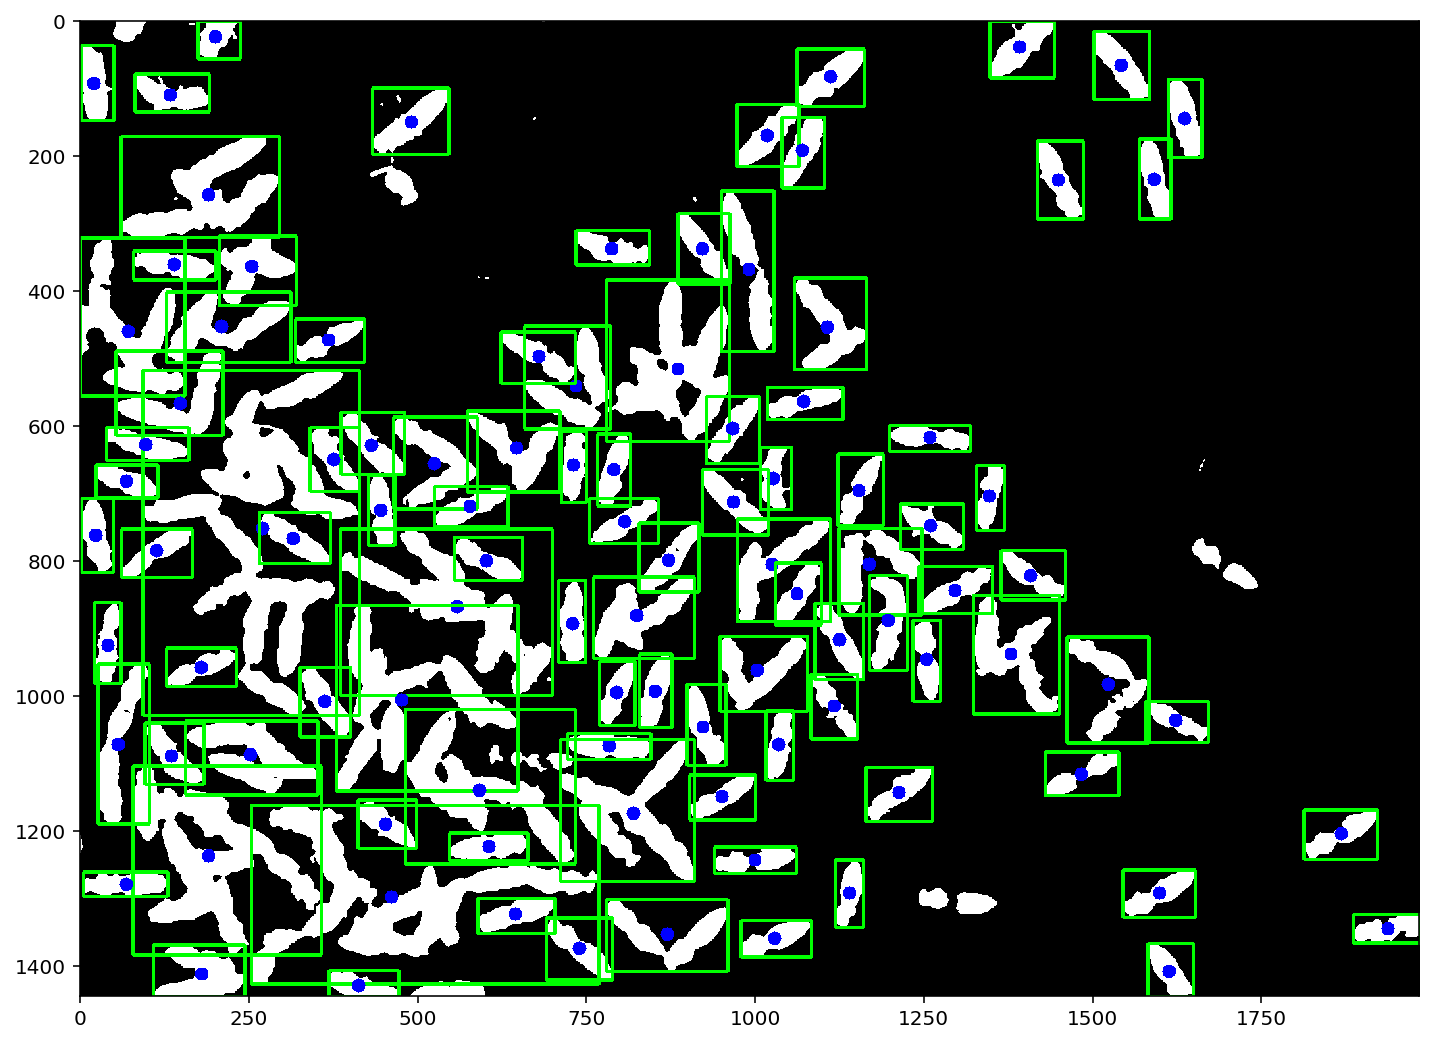

In [44]:
overlay_img = create_overlay_img(eroded_img, new_stats['local'], new_centroids)

# Crop Images

In [45]:
def get_squarish_rows_cols(num):
    factors = [i for i in range(2, num)[::-1] if num%i==0]
    if len(factors) == 1:
        rows, cols = factors[0], factors[0]
    elif len(factors) == 0:
        rows, cols = num, 1
    else:
        mid = len(factors)//2
        rows = factors[mid]
        cols = factors[mid-1]
    return rows, cols

In [ ]:
def crop_bees(img, stats):
    src_img = np.copy(img)
    cropped_imgs = []
    for stat in stats:
        top_left_x, top_left_y = stat[:2]
        h,w = stat[2:4]
        bottom_right = (top_left_x+h, top_left_y+w)
        cropped_img = src_img[top_left_y:top_left_y+w, top_left_x:top_left_x+h]
        cropped_imgs.append(cropped_img)
    try:
        cropped_imgs = np.array(cropped_imgs)
    except:
        cropped_imgs = None
        
    return cropped_imgs

In [47]:
cropped_imgs = crop_bees(img, new_stats['local'])
cropped_mask_imgs = crop_bees(eroded_img, new_stats['local'])

In [48]:
def plot_cropped_imgs(cropped_imgs, stats):
    nrows, ncols = get_squarish_rows_cols(len(cropped_imgs))
    
    if nrows == 1:
        if ncols > 10:
            fig, ax = plt.subplots(ncols, figsize=(12,12 + 2*ncols))
        else:
            fig, ax = plt.subplots(1, ncols, figsize=(12,12))
        for img_i in range(ncols):
            ax_i = ax[img_i]
            ax_i.imshow(cropped_imgs[img_i], cmap=plt.cm.gray)
            ax_i.set_title(f"Img {img_i}\nArea: {stats[img_i][-1]}")
    elif ncols == 1:
        if nrows > 10:
            fig, ax = plt.subplots(nrows, figsize=(12,12 + 2*nrows))
        else:
            fig, ax = plt.subplots(1, nrows, figsize=(12,12))
        for img_i in range(nrows):
            ax_i = ax[img_i]
            ax_i.imshow(cropped_imgs[img_i], cmap=plt.cm.gray)
            ax_i.set_title(f"Img {img_i}\nArea: {stats[img_i][-1]}")
    else:
        fig, ax = plt.subplots(nrows, ncols, figsize=(12,12))
        img_i = 0
        for row_i in range(nrows):
            for col_i in range(ncols):
                ax_i = ax[row_i][col_i]
                ax_i.imshow(cropped_imgs[img_i], cmap=plt.cm.gray)
                ax_i.set_title(f"Img {img_i}\nArea: {stats[img_i][-1]}")
                img_i += 1
    plt.tight_layout()

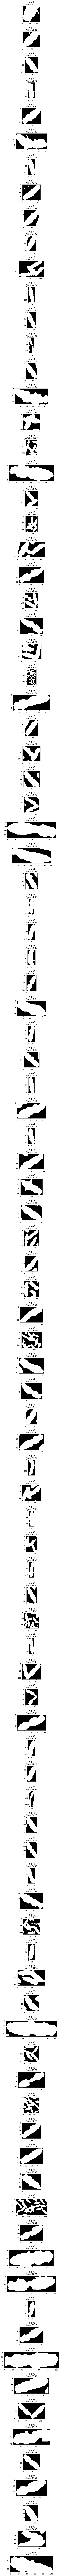

In [49]:
plot_cropped_imgs(cropped_mask_imgs, new_stats['local'])

In [ ]:
plot_cropped_imgs(cropped_imgs, new_stats['local'])

# Pick a Threshold
- From the above image, an area of 7000 seems to be a good threshold such that any areas > 7000 may contain > 1 bee.

In [50]:
SINGLE_BEE_AREA_THRESHOLD = 7000

# Select Image > Threshold and Check Open Morphology

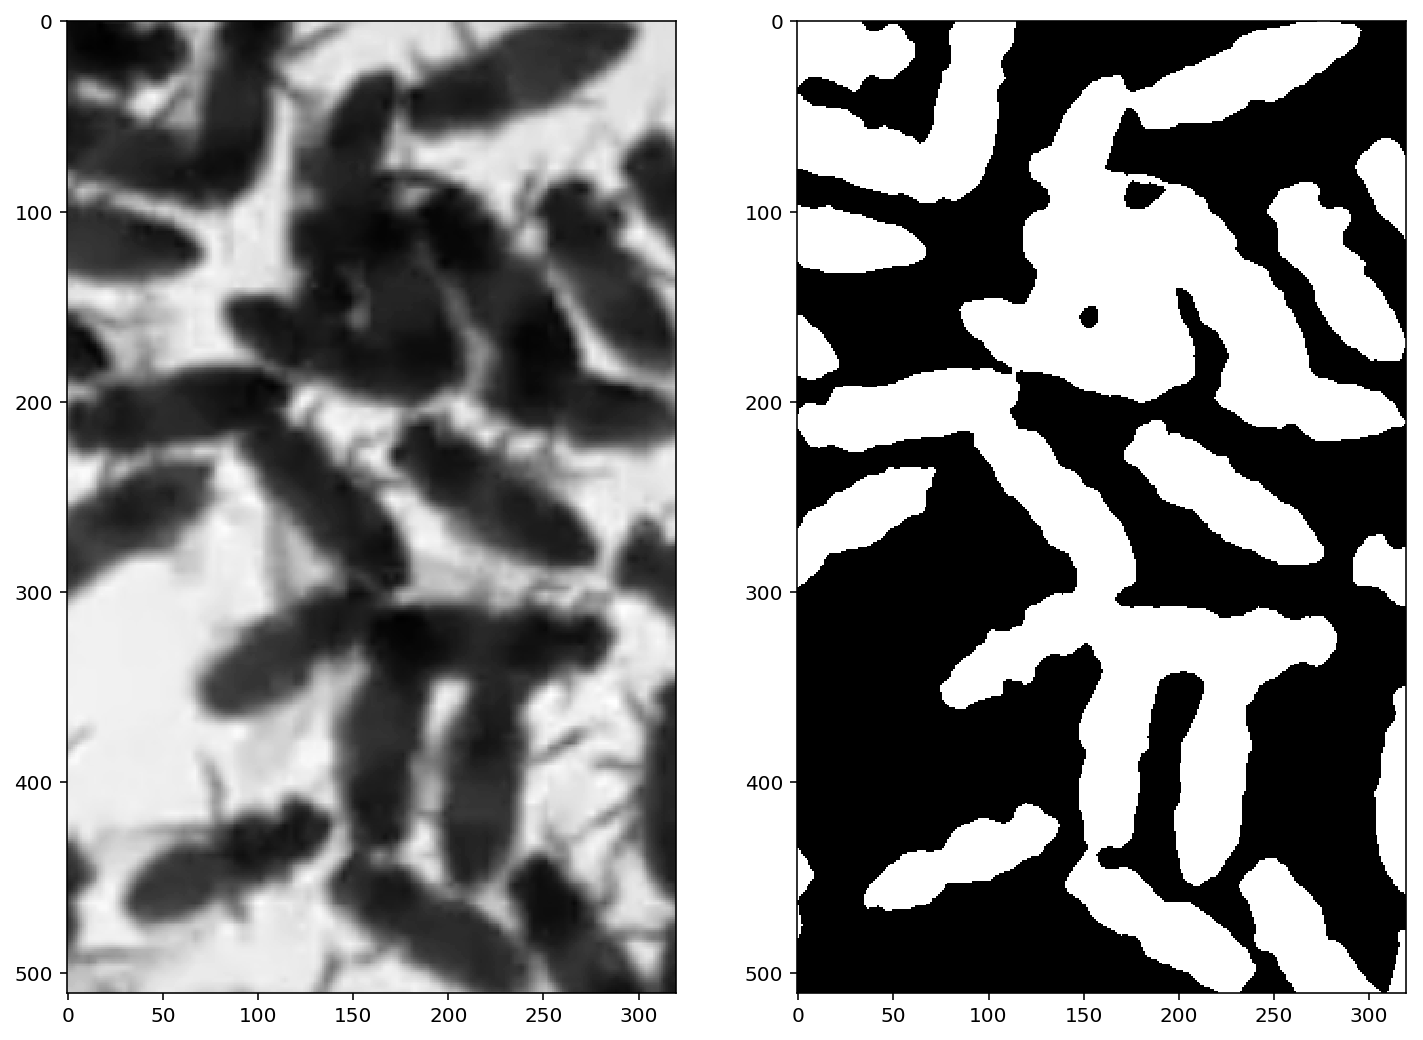

In [51]:
target_idx = 26
crop_img = cropped_imgs[target_idx]
crop_mask_img = cropped_mask_imgs[target_idx]
prev_stats = new_stats['global'][target_idx]
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(crop_img, cmap=plt.cm.gray)
ax[1].imshow(crop_mask_img, cmap=plt.cm.gray)

In [ ]:
new_stats_2, new_centroids_2 = run_connected_components(crop_mask_img, prev_stats)

In [ ]:
overlay_img_2 = create_overlay_img(crop_mask_img, new_stats_2['local'], new_centroids_2)

In [ ]:
cropped_imgs_2 = crop_bees(crop_img, new_stats_2['local'])
cropped_mask_imgs_2 = crop_bees(crop_mask_img, new_stats_2['local'])

In [ ]:
plot_cropped_imgs(cropped_imgs_2, new_stats_2['local'])

In [ ]:
plot_cropped_imgs(cropped_mask_imgs_2, new_stats_2['local'])

In [ ]:
global_cropped_imgs = crop_bees(img, new_stats_2['global'])

In [ ]:
plot_cropped_imgs(global_cropped_imgs, new_stats_2['global'])

# RUN

In [271]:
def sort_bees(stats, centroids):
    good_bees = {"stats" : {"global" : [], "local" : []}, "centroids" : []}
    bad_bees = {"stats" : {"global" : [], "local" : []}, "centroids" : []}
    
    for i in range(len(centroids)):
        centroid = centroids[i]
        local_stat = stats['local'][i]
        global_stat = stats['global'][i]
        area = global_stat[-1]
        if area <= SINGLE_BEE_AREA_THRESHOLD:
            container = good_bees
        else:
            container = bad_bees
            
        container['stats']['global'].append(global_stat)
        container['stats']['local'].append(local_stat)
        container['centroids'].append(centroid)
    
    if good_bees['stats']['global'] == []:
        good_bees = None
    
    if bad_bees['stats']['global'] == []:
        bad_bees = None
        
    return good_bees, bad_bees

In [308]:
def update_bees(container, bees):
    local_bee_stats = np.array(bees['stats']['local'])
    global_bee_stats = np.array(bees['stats']['global'])
    bee_centroids = np.array(bees['centroids'])
    
    if container['stats']['local'] is not None: 
        container['stats']['local'] = np.concatenate([container['stats']['local'], local_bee_stats], axis=0)
        container['stats']['global'] = np.concatenate([container['stats']['global'], global_bee_stats], axis=0)
        container['centroids'] = np.concatenate([container['centroids'], bee_centroids], axis=0)
    else:
        container['stats']['local'] = local_bee_stats
        container['stats']['global'] = global_bee_stats
        container['centroids'] = bee_centroids


## GO!

In [316]:
new_bad_bee_batch['centroids']

array([[208.5855597 , 136.82606835]])

In [330]:
cmap(0/NUM_ITERATIONS)

(0.0, 1.0, 1.0, 1.0)

In [338]:
np.array(cmap(i/NUM_ITERATIONS)[:3])*255

array([  0., 255., 255.])

In [341]:
def update_overlay(overlay_img, color_i, all_good_bees, new_bad_bee_batch):
    overlay_img = create_overlay_img(overlay_img, bee_type='good', show=False, 
                                     label_color=color_i,
                                     stats=all_good_bees['stats']['global'], 
                                     centroids=all_good_bees['centroids'])

    if new_bad_bee_batch['centroids'] is not None:
        overlay_img = create_overlay_img(overlay_img, bee_type='bad', show=False,
                                         stats=new_bad_bee_batch['stats']['global'], 
                                         centroids=new_bad_bee_batch['centroids'])
    return overlay_img

In [377]:
bad_bees

{'stats': {'global': array([[  253,  1161,   515,   265, 32714]], dtype=int32),
  'local': array([[    0,     0,   515,   265, 32714]], dtype=int32)},
 'centroids': array([[ 461.5855597 , 1297.82606835]])}

Iteration 0
Iteration 1
Iteration 2
Iteration 3


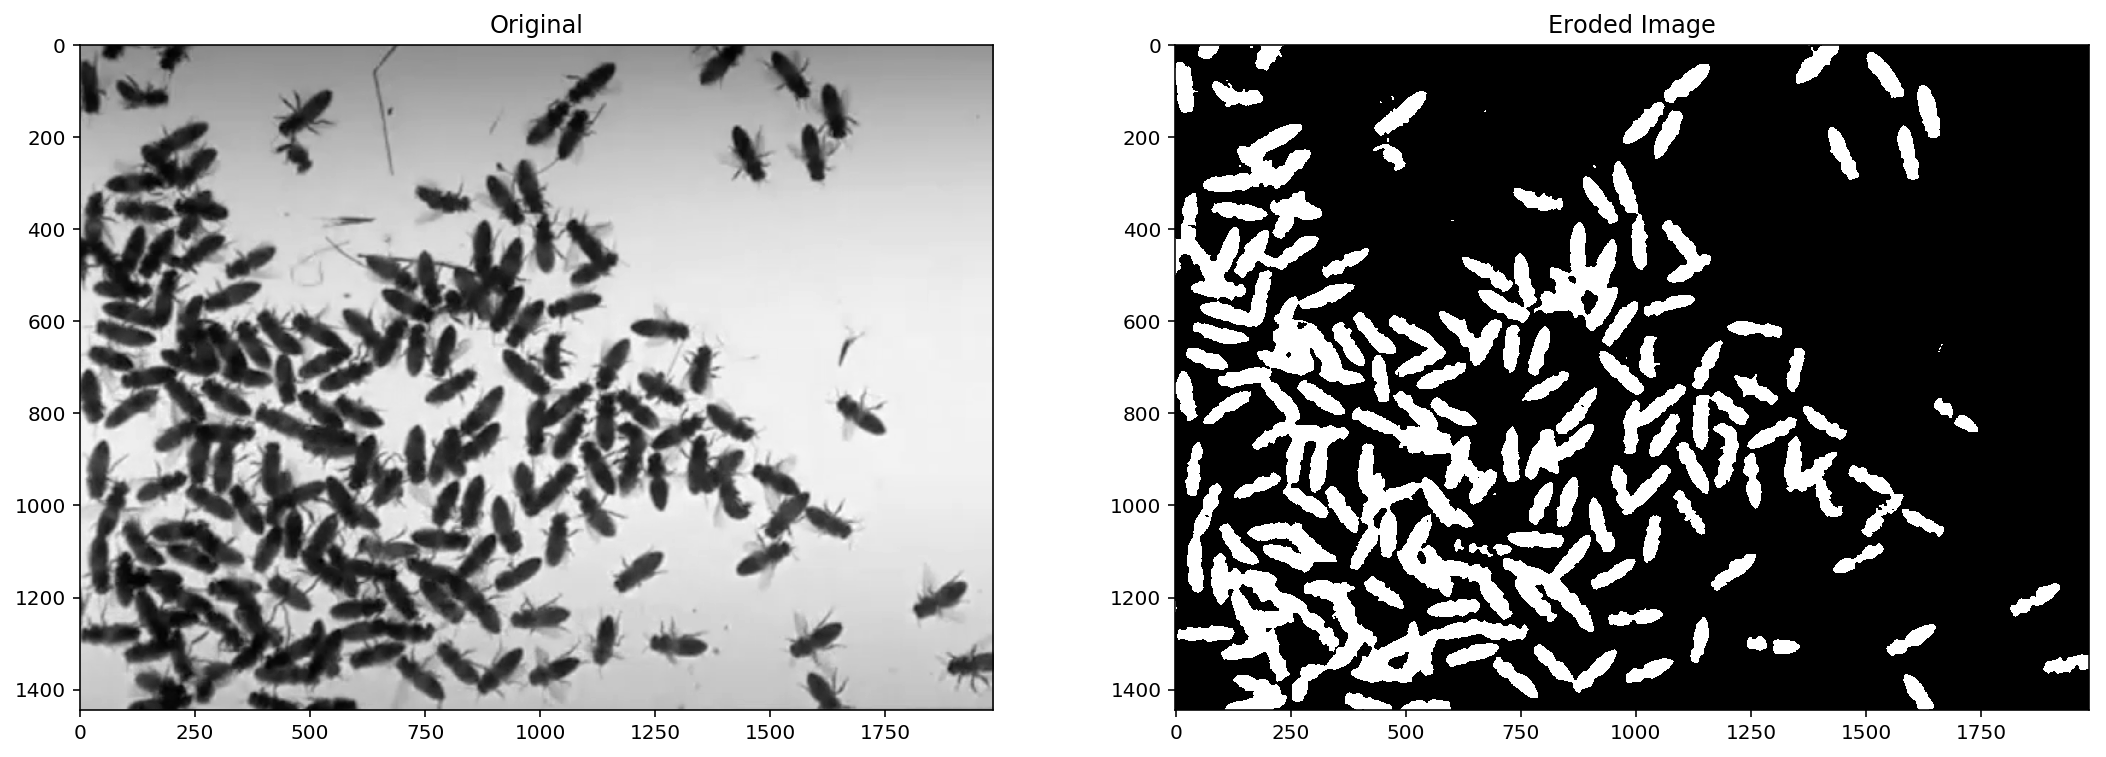

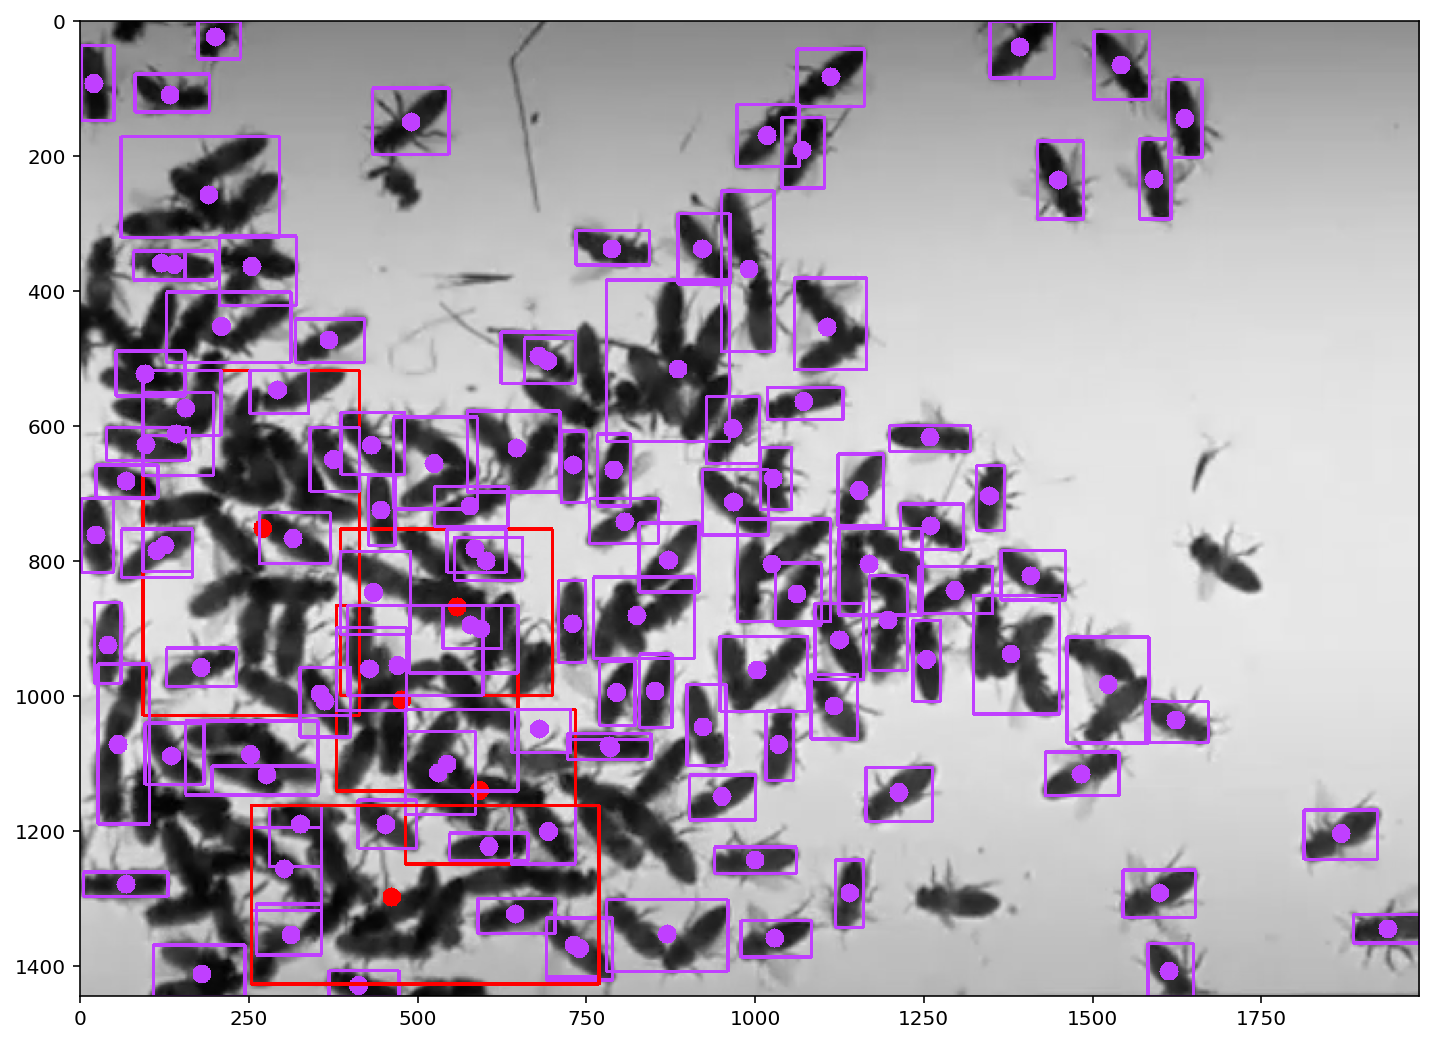

In [351]:
SINGLE_BEE_AREA_THRESHOLD = 7000
LOCAL = False
all_good_bees = {"stats" : {"global" : None, "local" : None}, "centroids" : None}
remaining_bad_bees = None

import pylab
NUM_ITERATIONS = 4

cmap = plt.cm.cool#pylab.get_cmap('gist_rainbow')

src_img = np.copy(img)
img_otsu_binary = threshold_image(src_img, show=False)

src_erode_img = img_otsu_binary if LOCAL else src_img
eroded_img = get_erroded_img(src_erode_img, local=LOCAL, show=True)

new_stats, new_centroids = run_connected_components(eroded_img)

good_bees, bad_bees = sort_bees(new_stats, new_centroids)
update_bees(all_good_bees, good_bees)

overlay_img = np.copy(img)

for i in range(NUM_ITERATIONS):
    print(f"Iteration {i}")
    color_i = np.array(cmap(i/NUM_ITERATIONS)[:3])*255
    new_stats = bad_bees['stats']
    new_centroids = bad_bees['centroids']
    
    cropped_imgs = crop_bees(src_img, new_stats['local'])
    new_bad_bee_batch = {"stats" : {"global" : None, "local" : None}, "centroids" : None} 
    for crop_i, cropped_img in enumerate(cropped_imgs):
        prev_centroids = new_centroids[crop_i]
        prev_stats = {
            "local"  : new_stats['local'][crop_i],
            "global" : new_stats['global'][crop_i],
        }

        src_img = np.copy(cropped_img)
        img_otsu_binary = threshold_image(src_img, show=False)
        eroded_img = get_erroded_img(src_img, local=False, show=False)
        new_stats_i, new_centroids_i = run_connected_components(eroded_img, prev_stats=prev_stats['global'])
        
        if new_centroids_i is None:
            prev_stats['local'] = np.expand_dims(prev_stats['local'], axis=0)
            prev_stats['global'] = np.expand_dims(prev_stats['global'], axis=0)
            prev_centroids = np.expand_dims(prev_centroids, axis=0)
            bad_bees_end = {
                "stats"     : prev_stats,
                "centroids" : prev_centroids
            }
            update_bees(all_good_bees, bad_bees_end)
            overlay_img = update_overlay(overlay_img, color_i, all_good_bees, new_bad_bee_batch)
            continue

        new_good_bees, new_bad_bees = sort_bees(new_stats_i, new_centroids_i)
        
        if new_good_bees is not None:
            update_bees(all_good_bees, new_good_bees)
        if new_bad_bees is not None:
            update_bees(new_bad_bee_batch, new_bad_bees)
            
        overlay_img = update_overlay(overlay_img, color_i, all_good_bees, new_bad_bee_batch)
    
    if new_bad_bee_batch['centroids'] is not None:
        bad_bees = new_bad_bee_batch
    else:
        bad_bees = None
        break

if bad_bees is not None:
    remaining_bad_bees = bad_bees  
    
# Plot overlays
# overlay_img = create_overlay_img(overlay_img, bee_type='good', i=i,
#                                  stats=all_good_bees['stats']['global'], 
#                                  centroids=all_good_bees['centroids'])

if remaining_bad_bees is not None:
    overlay_img = create_overlay_img(overlay_img, bee_type='bad',
                                     stats=remaining_bad_bees['stats']['global'], 
                                     centroids=remaining_bad_bees['centroids'])
